In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rachel/Documents/lfp2spikes/modularized_code') 
from models.GLM import GLM, LNL_POISSON

In [2]:
torch.manual_seed(42)
torch.__version__

'1.11.0+cu113'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
device

device(type='cuda')

In [4]:
torch.set_default_tensor_type(torch.DoubleTensor)

# DATA

### Load data

In [5]:
c=5

In [6]:
df_lfps_tvt = pd.read_pickle('../data_prep/data/pat66_lfps_df_ma_w30_o22_zscored_c5_split1.csv')
df_spikes_tvt = pd.read_pickle('../data_prep/data/pat66_spikes_df_ma_w30_o22_b1_c5_split1.csv')

df_random_tt = pd.read_pickle('../data_prep/data/pat66_random_split_df_ma_w30_o22_zscored_c5.csv')

In [5]:
buffer_size = 15
splits = [1,2,3,4,5]
bin_size = 1
c = (10, 1)
spike_type = "MUA"
spike_combo = "sumExt"
origin = 'zscored'

channels = "channels_1-5"

lfp_path = f'../data_prep/data/{spike_type}/{channels}/pat66_lfps{spike_type}_df_{origin}_c{c}'
spike_path = f'../data_prep/data/{spike_type}/{channels}/pat66_spikes{spike_type}_df_b{bin_size}_c{c}'



In [6]:
df_lfps_tvt.head()

NameError: name 'df_lfps_tvt' is not defined

### Create Dataset

In [212]:
class LSTMData(Dataset):
    
    def __init__(self, lfps, spikes, sequence_length):
        self.sequence_length = sequence_length
        self.y = torch.tensor(spikes).cuda()
        self.X = torch.tensor(lfps).cuda()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):         
        return self.X[i], self.y[i][0]

In [213]:
#sequence_length = len(df_lfps_tvt['train_dt'][0][0])
sequence_length = c
num_features = 1

train_data = LSTMData(
    np.array(df_lfps_tvt['train_dt'].tolist()).reshape(-1, sequence_length, num_features), 
    np.array(df_spikes_tvt['train_dt'].tolist()).reshape(-1, 1), 
    sequence_length
)

val_data = LSTMData(
    np.array(df_lfps_tvt['val_dt'].tolist()).reshape(-1, sequence_length, num_features), 
    np.array(df_spikes_tvt['val_dt'].tolist()).reshape(-1, 1), 
    sequence_length
)

test_data = LSTMData(
    np.array(df_lfps_tvt['test_dt'].tolist()).reshape(-1, sequence_length, num_features), 
    np.array(df_spikes_tvt['test_dt'].tolist()).reshape(-1, 1), 
    sequence_length
)

In [214]:
print(train_data.__len__())
print(val_data.__len__())
print(test_data.__len__())

369694
4602
4602


In [215]:
print(train_data[10])
print(df_lfps_tvt['train_dt'][0][10], df_spikes_tvt['train_dt'][0][10])

(tensor([[ 0.3506],
        [ 0.2303],
        [ 0.1538],
        [ 0.1084],
        [ 0.1796],
        [ 0.1670],
        [ 0.1356],
        [ 0.0554],
        [-0.0629],
        [-0.1227],
        [-0.1594],
        [-0.2087],
        [-0.2367],
        [-0.2035],
        [-0.1638],
        [-0.0552],
        [ 0.1294],
        [ 0.2635],
        [ 0.4057],
        [ 0.5303],
        [ 0.6164],
        [ 0.6899],
        [ 0.7864],
        [ 0.8587],
        [ 0.8904],
        [ 0.8925],
        [ 0.7602],
        [ 0.6200],
        [ 0.4942],
        [ 0.3830],
        [ 0.3370],
        [ 0.3015],
        [ 0.3625],
        [ 0.4515],
        [ 0.5796],
        [ 0.7242],
        [ 0.8073],
        [ 0.9102],
        [ 0.9171],
        [ 0.8836]], device='cuda:0'), tensor(-0.2792, device='cuda:0'))
[ 0.35057838  0.2303246   0.15376476  0.10839385  0.17955164  0.167041
  0.13563297  0.05538264 -0.0628808  -0.12274495 -0.15940439 -0.20874545
 -0.23669005 -0.20352652 -0.16376937 -0.05

### Data Loader

In [216]:
batch_size = 40
train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

In [13]:
x,y = next(iter(train_loader))
print(x.shape)
print(x)
print(y)

torch.Size([40, 5, 1])
tensor([[[ 2.7452e-01],
         [ 1.0298e-01],
         [ 4.8492e-02],
         [ 6.6267e-02],
         [ 8.7936e-02]],

        [[ 1.6122e-01],
         [ 2.2953e-01],
         [ 3.2125e-01],
         [ 4.0537e-01],
         [ 4.4872e-01]],

        [[ 3.0189e-01],
         [ 4.4366e-01],
         [ 5.7241e-01],
         [ 8.6072e-01],
         [ 1.1910e+00]],

        [[ 1.3170e+00],
         [ 1.3502e+00],
         [ 1.1510e+00],
         [ 1.0541e+00],
         [ 1.0470e+00]],

        [[-1.8554e-01],
         [ 4.1542e-01],
         [ 6.0871e-01],
         [ 8.4790e-01],
         [ 1.0516e+00]],

        [[ 9.6729e-01],
         [ 8.6074e-01],
         [ 7.6251e-01],
         [ 5.4478e-01],
         [ 3.5299e-01]],

        [[ 8.4332e-01],
         [ 8.7204e-01],
         [ 7.9653e-01],
         [ 6.9107e-01],
         [ 6.2152e-01]],

        [[ 1.0437e-01],
         [ 2.7192e-01],
         [ 3.7884e-01],
         [ 4.1740e-01],
         [ 4.7656e-01]],

 

# Build Network

In [205]:
class REGRESSION_LSTM(nn.Module):
    """
    LSTM core model for Active Tuning:
        -> LSTMCell
        -> if layer_norm=True: Layer Normalization
        -> linear layer
    """

    def __init__(
        self, 
        input_size, 
        hidden_size, 
        output_size,
        layer_norm=False
    ):

        self.device = device
        print(f'DEVICE REGRESSION_LSTM: {self.device}')

        super(REGRESSION_LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.output_size = output_size
        self.layer_norm = layer_norm
                
        self.lstm = nn.LSTM(
            input_size=self.input_size, 
            hidden_size=self.hidden_size, 
            batch_first=True, 
            bias=True, 
            num_layers=self.num_layers, 
            device=self.device
        )

        self.linear = nn.Linear(
            in_features=self.hidden_size, 
            out_features=self.output_size, 
            device=self.device
        )


    def forward(self, x):
        
        batch_size = x.shape[0]
        (h0, c0) = self.init_hidden(batch_size)
                
        _, (hn, _) = self.lstm(x, (h0,c0))        
        prediction = self.linear(hn[0]).flatten()

        return prediction

    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(self.device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_().to(self.device))


In [206]:
def train_regLSTM(data_loader, model, loss_function, optimizer): 
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        out = model(X)
        loss = loss_function(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    mean_loss = total_loss / num_batches
    print(f"Training loss: {mean_loss}")
    
    return mean_loss
    
    
def test_regLSTM(data_loader, model, loss_function, modus): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            out = model(X)
            total_loss += loss_function(out, y).item()

    mean_loss = total_loss / num_batches
    print(f"{modus} loss: {mean_loss}")
    
    return mean_loss

In [217]:
learning_rate = 1e-3
weight_decay = 0.1
momentum = 0.9
num_hidden = 10
num_input = 1 
num_output = 1 # 1 

num_epochs = 30

model = REGRESSION_LSTM(
    input_size=num_input, 
    hidden_size=num_hidden, 
    output_size=num_output)
loss_function = nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

DEVICE REGRESSION_LSTM: cuda


### Model Training

In [218]:
print("Untrained test\n--------")
test_regLSTM(val_loader, model, loss_function, "Validation")
print()

train_losses = []
val_losses = []
for ep in range(num_epochs):
    print(f"E'poch {ep}\n---------")
    train_losses.append(
        train_regLSTM(
            train_loader, 
            model, 
            loss_function, 
            optimizer=optimizer
        )
    )
    val_losses.append(
        test_regLSTM(
            val_loader, 
            model, 
            loss_function, 
            "Validation"
        )
    )
    print()    


Untrained test
--------
Validation loss: 0.17464885012452366

E'poch 0
---------
Training loss: 0.1419188714850506
Validation loss: 0.14593048660364702

E'poch 1
---------
Training loss: 0.14147779096389296
Validation loss: 0.1459132779163909

E'poch 2
---------
Training loss: 0.14144276762592628
Validation loss: 0.14593944001320697

E'poch 3
---------
Training loss: 0.14142626371745584
Validation loss: 0.14586648028010823

E'poch 4
---------
Training loss: 0.14138879053886158
Validation loss: 0.14604274919684637

E'poch 5
---------
Training loss: 0.14142728307622665
Validation loss: 0.1459618349120714

E'poch 6
---------
Training loss: 0.14136939508678997
Validation loss: 0.14586442717033574

E'poch 7
---------
Training loss: 0.14135756371715458
Validation loss: 0.14588507118749758

E'poch 8
---------
Training loss: 0.14134845999614312
Validation loss: 0.1461877403689749

E'poch 9
---------
Training loss: 0.14134786793668702
Validation loss: 0.14619816680741185

E'poch 10
---------
Tr

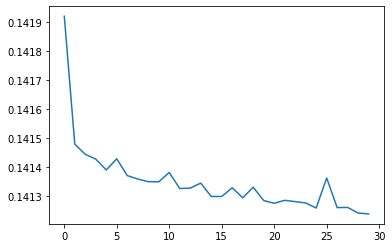

In [220]:
plt.plot(train_losses) 

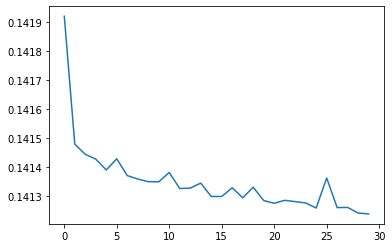

In [219]:
plt.plot(train_losses) 

#### lr=5e-3, decay=0.0, hidden=50

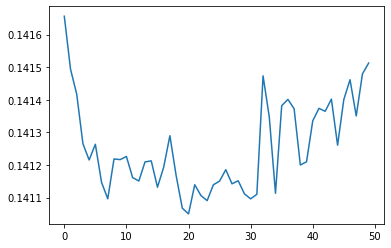

In [128]:
plt.plot(train_losses) 

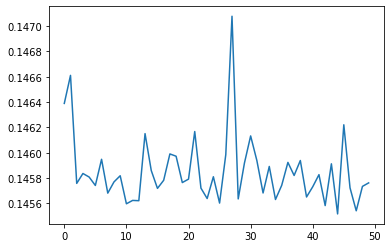

In [129]:
plt.plot(val_losses) 

## ALL
c = 40
split = 1
bin_size = 1
w = 30
o = 22
spike_type = "ALL"
origin = 'zscored'

channels = "all_channels"

#### lr=1e-3, momentum=0.2, hidden=50

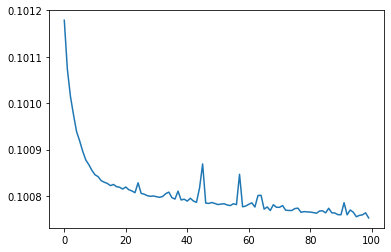

In [113]:
plt.plot(train_losses) 

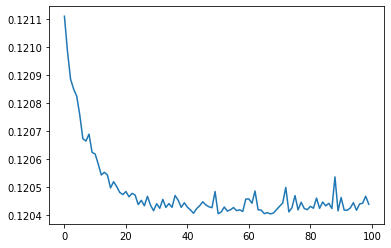

In [112]:
plt.plot(val_losses) 

#### lr=5e-3, momentum=0.1, hidden=100

#### lr=5e-3, momentum=0.1, hidden=100

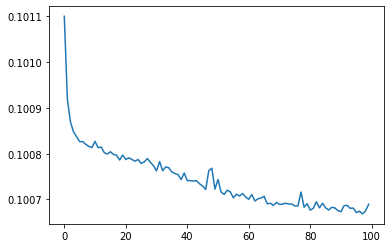

In [106]:
plt.plot(train_losses) 

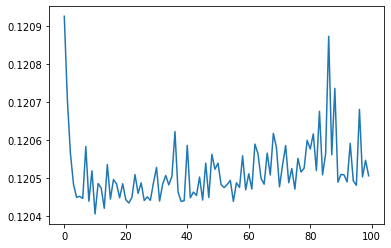

In [107]:
plt.plot(val_losses) 

#### lr=1e-2, momentum=0.4, hidden=100

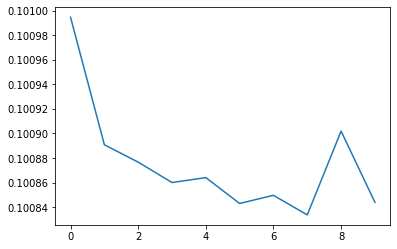

In [98]:
plt.plot(train_losses) 

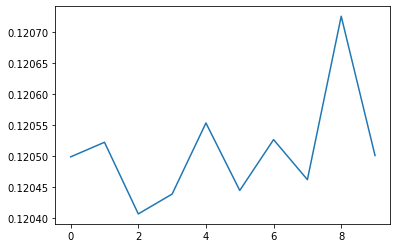

In [99]:
plt.plot(val_losses) 

#### lr=1e-3, momentum=0.1, hidden=100

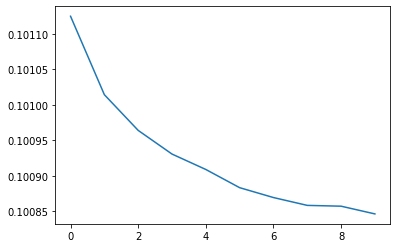

In [84]:
plt.plot(train_losses) 

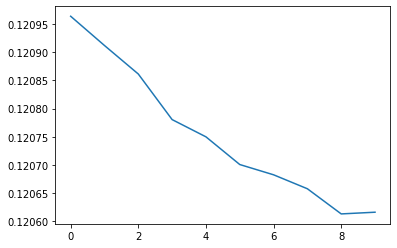

In [85]:
plt.plot(val_losses) 

#### lr=1e-3, momentum=0.0, hidden=100

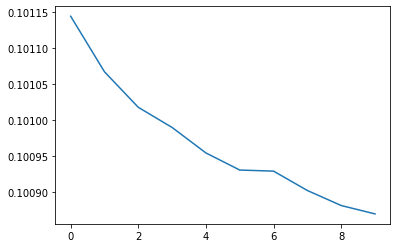

In [80]:
plt.plot(train_losses) 

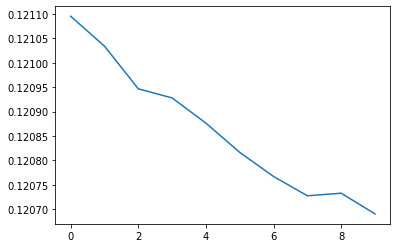

In [81]:
plt.plot(val_losses) 

#### lr=1e-3, decay=1e-5, hidden=100

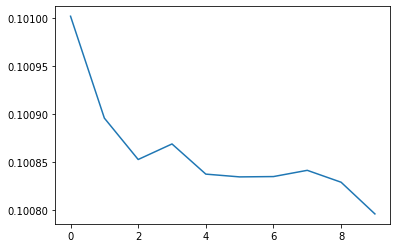

In [75]:
plt.plot(train_losses) 

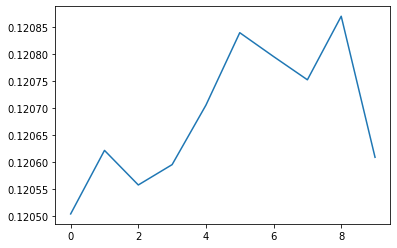

In [76]:
plt.plot(val_losses) 

#### lr=1e-3, decay=1e-6, hidden=50

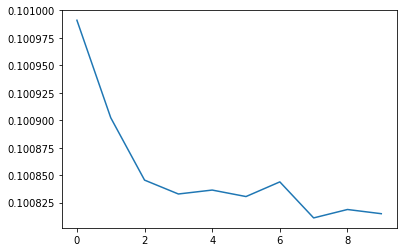

In [71]:
plt.plot(train_losses) 

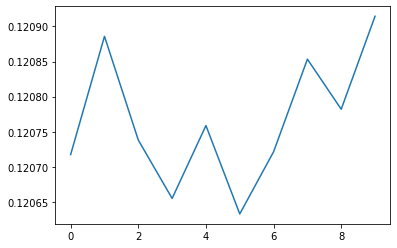

In [72]:
plt.plot(val_losses) 

#### lr=1e-3, decay=0.0, hidden=100

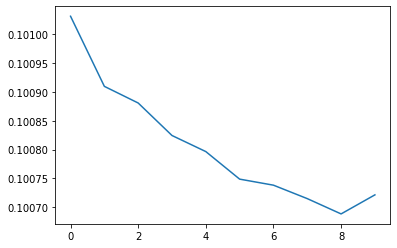

In [67]:
plt.plot(train_losses) 

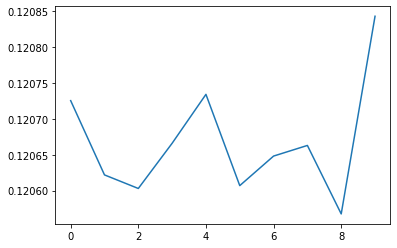

In [68]:
plt.plot(val_losses)

#### lr=1e-2, decay=0.0, hidden=50

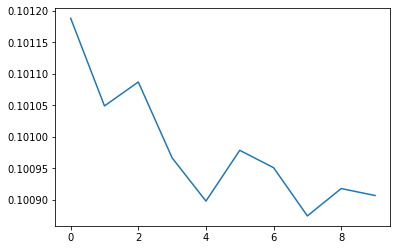

In [62]:
plt.plot(train_losses) 

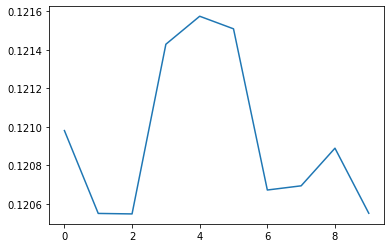

In [63]:
plt.plot(val_losses)

#### lr=1e-3, decay=0.0, hidden=50

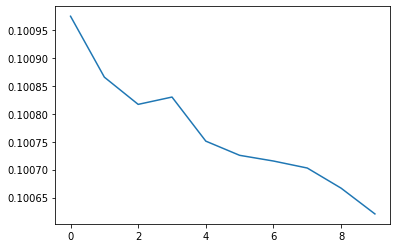

In [58]:
plt.plot(train_losses) 

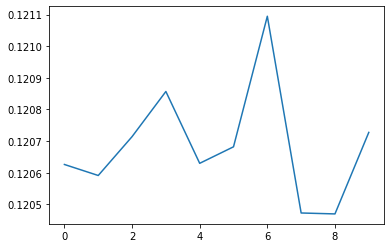

In [59]:
plt.plot(val_losses)